In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit

def load_triggers(df, hg_threshold):
    total_triggers = len(df) // 64
    if total_triggers == 0:
        return []

    timestamps_arr = df['Tstamp_us'].values
    hg_arr = df['HG'].values
    ch_arr = df['Ch'].values

    triggers = []
    for i in tqdm(range(total_triggers), desc="Processing triggers"):
        start = i * 64
        end = start + 64
        
        timestamp = timestamps_arr[start]
        
        block_mask = (hg_arr[start:end] > hg_threshold)
        active_channels = ch_arr[start:end][block_mask]
        
        triggers.append({"timestamp": timestamp, "channels": active_channels})
    
    return triggers

def match_triggers(triggers_D1, triggers_D2, tolerance):
    coincidences = []
    i, j = 0, 0
    while i < len(triggers_D1) and j < len(triggers_D2):
        t1 = triggers_D1[i]["timestamp"]
        t2 = triggers_D2[j]["timestamp"]
        dt = t1 - t2
        if abs(dt) <= tolerance:
            coincidences.append((triggers_D1[i], triggers_D2[j]))
            i += 1
            j += 1
        elif dt < 0:
            i += 1
        else:
            j += 1
    return coincidences

def linear_model(x, a):
    return a * x

def calc_eff_and_error(a, b):
    eff = {}
    err = {}
    for ch in a:
        A = a[ch]
        B = b[ch]
        C = A + B
        if C > 0:
            eff[ch] = B / C
            error = np.sqrt((A**2 * B + B**2 * A) / C**4)
            err[ch] = error
        else:
            eff[ch] = np.nan
            err[ch] = np.nan
    return eff, err

def coincidences_verification(coincidences):

    times_D1 = np.array([pair[0]["timestamp"] for pair in coincidences])
    times_D2 = np.array([pair[1]["timestamp"] for pair in coincidences])

    rel_times_D1 = times_D1 - times_D1[0]
    rel_times_D2 = times_D2 - times_D2[0]

    delta_t = rel_times_D1 - rel_times_D2
    delta_t_abs = np.abs(delta_t)

    print(f"Mean Δt: {np.mean(delta_t):.2f} µs")
    print(f"Standard deviation: {np.std(delta_t):.2f} µs")

    x_vals = np.arange(len(delta_t))
    popt, pcov = curve_fit(linear_model, x_vals, delta_t)

    slope = popt[0]
    slope_err = np.sqrt(pcov[0, 0])

    y_fit = linear_model(x_vals, slope)
    r_squared = np.corrcoef(y_fit, delta_t)[0, 1] ** 2

    print(f"Slope: {slope:.4g} ± {slope_err:.4g} µs/event")
    print(f"R²: {r_squared:.6f}")

    plt.figure(figsize=(12, 5))
    plt.scatter(x_vals, delta_t, label='ΔRelative Time (D1 - D2)')
    plt.plot(x_vals, y_fit, color='orange', label=f'Fit: f(x) = {slope:.4g}x')
    plt.axhline(np.mean(delta_t), color='red', linestyle='--', label='Mean Δt')
    plt.title("Relative Time Difference between Matched Triggers")
    plt.xlabel("Event index")
    plt.ylabel("Δt (µs)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

    return delta_t_abs


def plot_efficiency_vs_channel(efficiency, errors, title="Efficiency vs Channel"):

    channels = np.array(sorted(efficiency.keys()))
    values = np.array([efficiency.get(ch, np.nan) for ch in channels])
    err_vals = np.array([errors.get(ch, np.nan) for ch in channels])

    avg = np.nanmean(values)
    std = np.nanstd(values)

    plt.figure(figsize=(15, 5))
    plt.errorbar(channels, values, yerr=err_vals, fmt='o', capsize=3, label=f"std: {std:.3f}")

    plt.axhline(avg, color='r', linestyle='--', label=f"mean: {avg:.3f}")
    plt.title(title)
    plt.xlabel("Channel")
    plt.ylabel("Efficiency")
    plt.xticks(np.arange(min(channels), max(channels)+1, 1))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.ylim(0, 1.1)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_event_counts_per_channel(C_muon_dict, title="Muon-pattern Event Counts per Channel"):
    channels = sorted(C_muon_dict.keys())
    counts = [C_muon_dict[ch] for ch in channels]

    plt.figure(figsize=(15, 5))
    plt.bar(channels, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Channel")
    plt.ylabel("Number of Events (C_muon)")
    plt.xticks(np.arange(min(channels), max(channels)+1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_HG_distribution(df, bins=100, range=None):

    hg_values = df["HG"].values

    plt.figure(figsize=(10, 5))
    plt.hist(hg_values, bins=bins, range=range, color="royalblue", edgecolor="black", alpha=0.8)
    plt.xlabel("HG (High Gain)")
    plt.ylabel("Frecuency")
    plt.title("HG Distribution")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [2]:
def compute_efficiency1(triggers_D1, triggers_D2, X_D1, Y_D1, X_D2, Y_D2):

    C_7act_i_D1 = {i: 0 for i in X_D1}
    C_8act_i_D1 = {i: 0 for i in X_D1}
    C_7act_j_D1 = {j: 0 for j in Y_D1}
    C_8act_j_D1 = {j: 0 for j in Y_D1}

    C_7act_i_D2 = {i: 0 for i in X_D2}
    C_8act_i_D2 = {i: 0 for i in X_D2}
    C_7act_j_D2 = {j: 0 for j in Y_D2}
    C_8act_j_D2 = {j: 0 for j in Y_D2}

    coincidences = list(zip(triggers_D1, triggers_D2))

    for pair in tqdm(coincidences, desc="Processing coincidences"):
        active_D1 = pair[0]["channels"]
        active_D2 = pair[1]["channels"]

        if (len(active_D1) == 4) and (len(active_D2) == 4):
            conditions1 = (active_D1[0] == active_D1[1] - 1) and (active_D1[2] == active_D1[3] - 1) \
                                and (-1 < active_D1[0] < 29) and ( 31 < active_D1[2] < 61)
            conditions2 = (active_D2[0] == active_D2[1] - 1) and (active_D2[2] == active_D2[3] - 1) \
                                and (-1 < active_D2[0] < 29) and ( 31 < active_D2[2] < 61)
             
            if conditions1 and conditions2:
                C_8act_i_D1[active_D1[0]] += 1
                C_8act_i_D1[active_D1[1]] += 1
                C_8act_j_D1[active_D1[2]] += 1
                C_8act_j_D1[active_D1[3]] += 1

                C_8act_i_D2[active_D2[0]] += 1
                C_8act_i_D2[active_D2[1]] += 1
                C_8act_j_D2[active_D2[2]] += 1
                C_8act_j_D2[active_D2[3]] += 1

        elif (len(active_D1) == 3) and (len(active_D2) == 4):
            conditions1 = (active_D1[0] == active_D1[1] - 1) and (-1 < active_D1[0] < 29) and (32 < active_D1[2] < 60)
            conditions2 = (active_D1[1] == active_D1[2] - 1) and ( 31 < active_D1[1] < 61) and (0 < active_D1[0] < 28)
            conditions3 = (active_D2[0] == active_D2[1] - 1) and (active_D2[2] == active_D2[3] - 1) \
                                and (-1 < active_D2[0] < 29) and ( 31 < active_D2[2] < 61)
            
            if conditions1 and conditions3:
                C_7act_j_D1[active_D1[2] + 1] += 1
                C_7act_j_D1[active_D1[2] - 1] += 1

            elif conditions2 and conditions3:
                C_7act_i_D1[active_D1[0] + 1] += 1
                C_7act_i_D1[active_D1[0] - 1] += 1
        
        elif (len(active_D1) == 4) and (len(active_D2) == 3):
            conditions1 = (active_D2[0] == active_D2[1] - 1) and (-1 < active_D2[0] < 29) and (32 < active_D2[2] < 60)
            conditions2 = (active_D2[1] == active_D2[2] - 1) and ( 31 < active_D2[1] < 61) and (0 < active_D2[0] < 28)
            conditions3 = (active_D1[0] == active_D1[1] - 1) and (active_D1[2] == active_D1[3] - 1) \
                                and (-1 < active_D1[0] < 29) and ( 31 < active_D1[2] < 61)
            
            if conditions1 and conditions3:
                C_7act_j_D2[active_D2[2] + 1] += 1
                C_7act_j_D2[active_D2[2] - 1] += 1

            elif conditions2 and conditions3:
                C_7act_i_D2[active_D2[0] + 1] += 1
                C_7act_i_D2[active_D2[0] - 1] += 1

    eff_i_D1, err_i_D1 = calc_eff_and_error(C_7act_i_D1, C_8act_i_D1)
    eff_j_D1, err_j_D1 = calc_eff_and_error(C_7act_j_D1, C_8act_j_D1)

    eff_i_D2, err_i_D2 = calc_eff_and_error(C_7act_i_D2, C_8act_i_D2)
    eff_j_D2, err_j_D2 = calc_eff_and_error(C_7act_j_D2, C_8act_j_D2)

    eff = [eff_i_D1, eff_j_D1, eff_i_D2, eff_j_D2]
    err = [err_i_D1, err_j_D1, err_i_D2, err_j_D2]
    C_7act = [C_7act_i_D1, C_7act_j_D1, C_7act_i_D2, C_7act_j_D2]
    C_8act = [C_8act_i_D1, C_8act_j_D1, C_8act_i_D2, C_8act_j_D2]

    return eff, err, C_7act, C_8act

In [3]:
def compute_efficiency2(triggers_D1, triggers_D2, X_D1, Y_D1, X_D2, Y_D2):
    C_7act_i_D1 = {i: 0 for i in X_D1}
    C_8act_i_D1 = {i: 0 for i in X_D1}
    C_7act_j_D1 = {j: 0 for j in Y_D1}
    C_8act_j_D1 = {j: 0 for j in Y_D1}

    C_7act_i_D2 = {i: 0 for i in X_D2}
    C_8act_i_D2 = {i: 0 for i in X_D2}
    C_7act_j_D2 = {j: 0 for j in Y_D2}
    C_8act_j_D2 = {j: 0 for j in Y_D2}

    coincidences = list(zip(triggers_D1, triggers_D2))

    for pair in tqdm(coincidences, desc="Processing coincidences"):
        channels_D1 = set(pair[0]["channels"])
        channels_D2 = set(pair[1]["channels"])

        if len(channels_D1) < 5 and len(channels_D2) < 5:

            for i in X_D1:
                if len(channels_D2) == 4:

                    vecinos_i = i - 1 in channels_D1 or i + 1 in channels_D1
                    vecinos_j = any(j in channels_D1 and (j - 1 in channels_D1 or j + 1 in channels_D1) for j in Y_D1)
                    vecinos_i_D2 = any(i2 in channels_D2 and (i2 - 1 in channels_D2 or i2 + 1 in channels_D2) for i2 in X_D2)
                    vecinos_j_D2 = any(j2 in channels_D2 and (j2 - 1 in channels_D2 or j2 + 1 in channels_D2) for j2 in Y_D2)

                    if vecinos_i and vecinos_j and vecinos_i_D2 and vecinos_j_D2:
                        if (i not in channels_D1) and len(channels_D1) == 3:
                            C_7act_i_D1[i] += 1
                        elif (i in channels_D1) and len(channels_D1) == 4:
                            C_8act_i_D1[i] += 1
            
            for j in Y_D1:
                if len(channels_D2) == 4:

                    vecinos_j = j - 1 in channels_D1 or j + 1 in channels_D1
                    vecinos_i = any(i in channels_D1 and (i - 1 in channels_D1 or i + 1 in channels_D1) for i in X_D1)
                    vecinos_j_D2 = any(j2 in channels_D2 and (j2 - 1 in channels_D2 or j2 + 1 in channels_D2) for j2 in Y_D2)
                    vecinos_i_D2 = any(i2 in channels_D2 and (i2 - 1 in channels_D2 or i2 + 1 in channels_D2) for i2 in X_D2)

                    if vecinos_j and vecinos_i and vecinos_j_D2 and vecinos_i_D2:
                        if (j not in channels_D1) and len(channels_D1) == 3:
                            C_7act_j_D1[j] += 1
                        elif (j in channels_D1) and len(channels_D1) == 4:
                            C_8act_j_D1[j] += 1
            
            for i in X_D2:
                if len(channels_D1) == 4:

                    vecinos_i = i - 1 in channels_D2 or i + 1 in channels_D2
                    vecinos_j = any(j in channels_D2 and (j - 1 in channels_D2 or j + 1 in channels_D2) for j in Y_D2)
                    vecinos_i_D2 = any(i2 in channels_D1 and (i2 - 1 in channels_D1 or i2 + 1 in channels_D1) for i2 in X_D1)
                    vecinos_j_D2 = any(j2 in channels_D1 and (j2 - 1 in channels_D1 or j2 + 1 in channels_D1) for j2 in Y_D1)

                    if vecinos_i and vecinos_j and vecinos_i_D2 and vecinos_j_D2:
                        if (i not in channels_D2) and len(channels_D2) == 3:
                            C_7act_i_D2[i] += 1
                        elif (i in channels_D2) and len(channels_D2) == 4:
                            C_8act_i_D2[i] += 1
            
            for j in Y_D2:
                if len(channels_D1) == 4:

                    vecinos_j = j - 1 in channels_D2 or j + 1 in channels_D2
                    vecinos_i = any(i in channels_D2 and (i - 1 in channels_D2 or i + 1 in channels_D2) for i in X_D2)
                    vecinos_j_D2 = any(j2 in channels_D1 and (j2 - 1 in channels_D1 or j2 + 1 in channels_D1) for j2 in Y_D1)
                    vecinos_i_D2 = any(i2 in channels_D1 and (i2 - 1 in channels_D1 or i2 + 1 in channels_D1) for i2 in X_D1)

                    if vecinos_j and vecinos_i and vecinos_j_D2 and vecinos_i_D2:
                        if (j not in channels_D2) and len(channels_D2) == 3:
                            C_7act_j_D2[j] += 1
                        elif (j in channels_D2) and len(channels_D2) == 4:
                            C_8act_j_D2[j] += 1
        
    eff_i_D1, err_i_D1 = calc_eff_and_error(C_7act_i_D1, C_8act_i_D1)
    eff_j_D1, err_j_D1 = calc_eff_and_error(C_7act_j_D1, C_8act_j_D1)

    eff_i_D2, err_i_D2 = calc_eff_and_error(C_7act_i_D2, C_8act_i_D2)
    eff_j_D2, err_j_D2 = calc_eff_and_error(C_7act_j_D2, C_8act_j_D2)

    eff = [eff_i_D1, eff_j_D1, eff_i_D2, eff_j_D2]
    err = [err_i_D1, err_j_D1, err_i_D2, err_j_D2]
    C_7act = [C_7act_i_D1, C_7act_j_D1, C_7act_i_D2, C_7act_j_D2]
    C_8act = [C_8act_i_D1, C_8act_j_D1, C_8act_i_D2, C_8act_j_D2]

    return eff, err, C_7act, C_8act


In [4]:
def compute_efficiency3(triggers, X, Y):
    C_3act_i = {i: 0 for i in X}
    C_4act_i = {i: 0 for i in X}
    C_3act_j = {j: 0 for j in Y}
    C_4act_j = {j: 0 for j in Y}

    for trig in tqdm(triggers):
        active = set(trig["channels"])

        if len(active) < 5:

            for i in X:
                has_neighbor_i = ((i - 1 in active and i - 1 in X) or (i + 1 in active and i + 1 in X))
                for j in Y:
                    has_j = j in active
                    has_neighbor_j = ((j - 1 in active and j - 1 in Y) or (j + 1 in active and j + 1 in Y))
                    if has_neighbor_i and has_j and has_neighbor_j:
                        if i not in active and len(active) == 3:
                            C_3act_i[i] += 1
                        elif i in active and len(active) == 4:
                            C_4act_i[i] += 1
                        break

            for j in Y:
                has_neighbor_j = ((j - 1 in active and j - 1 in Y) or (j + 1 in active and j + 1 in Y))
                for i in X:
                    has_i = i in active
                    has_neighbor_i = ((i - 1 in active and i - 1 in X) or (i + 1 in active and i + 1 in X))

                    if has_neighbor_j and has_i and has_neighbor_i:
                        if j not in active and len(active) == 3:
                            C_3act_j[j] += 1
                        elif j in active and len(active) == 4:
                            C_4act_j[j] += 1
                        break

    eff_i, err_i = calc_eff_and_error(C_3act_i, C_4act_i)
    eff_j, err_j = calc_eff_and_error(C_3act_j, C_4act_j)

    eff = [eff_i, eff_j]
    err = [err_i, err_j]
    C_3act = [C_3act_i, C_3act_j]
    C_4act = [C_4act_i, C_4act_j]

    return eff, err, C_3act, C_4act


def compute_efficiency4(triggers, X, Y):
    C_3act_i = {i: 0 for i in X}
    C_4act_i = {i: 0 for i in X}
    C_3act_j = {j: 0 for j in Y}
    C_4act_j = {j: 0 for j in Y}
    
    for trig in tqdm(triggers):
        active = trig["channels"]

        if (len(active) == 4):
             if (active[0] == active[1] - 1) and (active[2] == active[3] - 1) and (-1 < active[0] < 29) and ( 31 < active[2] < 61):
                C_4act_i[active[0]] += 1
                C_4act_i[active[1]] += 1
                C_4act_j[active[2]] += 1
                C_4act_j[active[3]] += 1

        elif (len(active) == 3):
            if (active[0] == active[1] - 1) and (-1 < active[0] < 29) and (32 < active[2] < 60):
                C_3act_j[active[2] + 1] += 1
                C_3act_j[active[2] - 1] += 1
                
            elif (active[1] == active[2] - 1) and ( 31 < active[1] < 61) and (0 < active[0] < 28):
                C_3act_i[active[0] + 1] += 1
                C_3act_i[active[0] - 1] += 1

    eff_i, err_i = calc_eff_and_error(C_3act_i, C_4act_i)
    eff_j, err_j = calc_eff_and_error(C_3act_j, C_4act_j)

    eff = [eff_i, eff_j]
    err = [err_i, err_j]
    C_3act = [C_3act_i, C_3act_j]
    C_4act = [C_4act_i, C_4act_j]

    return eff, err, C_3act, C_4act

# Load Data

In [5]:
df1 = pd.read_parquet("data/Toma_datos_lider_15h.parquet", engine='pyarrow')
#df1 = df1.drop(['Brd', 'LG'], axis=1)

df2 = pd.read_parquet("data/Toma_datos_subdito_15h.parquet", engine='pyarrow')
df2.rename(columns={'Ch': 'LG', 'LG':'Ch',}, inplace=True)
#df2 = df2.drop(['Brd', 'LG'], axis=1)

# Select Data

In [14]:
hg_threshold = 1000
triggers_D1 = load_triggers(df1, hg_threshold)
triggers_D2 = load_triggers(df2, hg_threshold)

Processing triggers: 100%|██████████| 1905689/1905689 [00:08<00:00, 228010.09it/s]


# HG Disribution

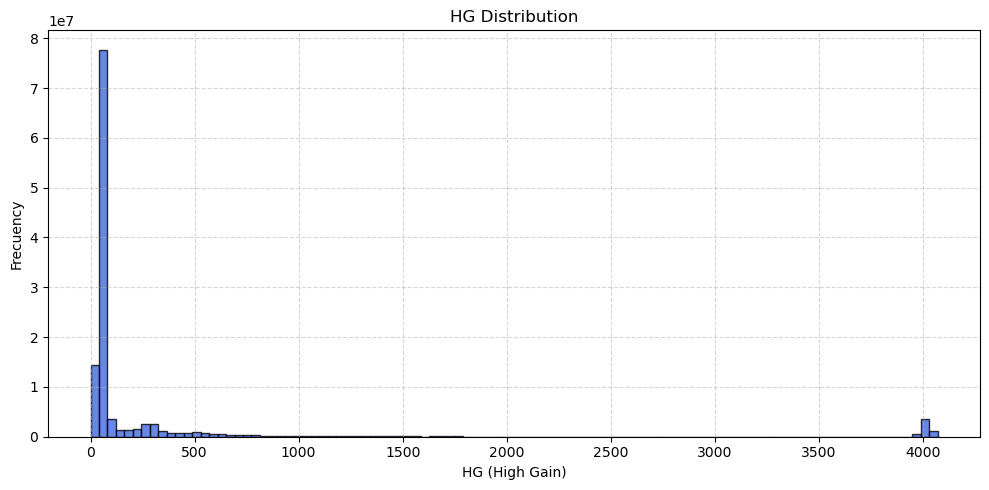

In [16]:
plot_HG_distribution(df1)

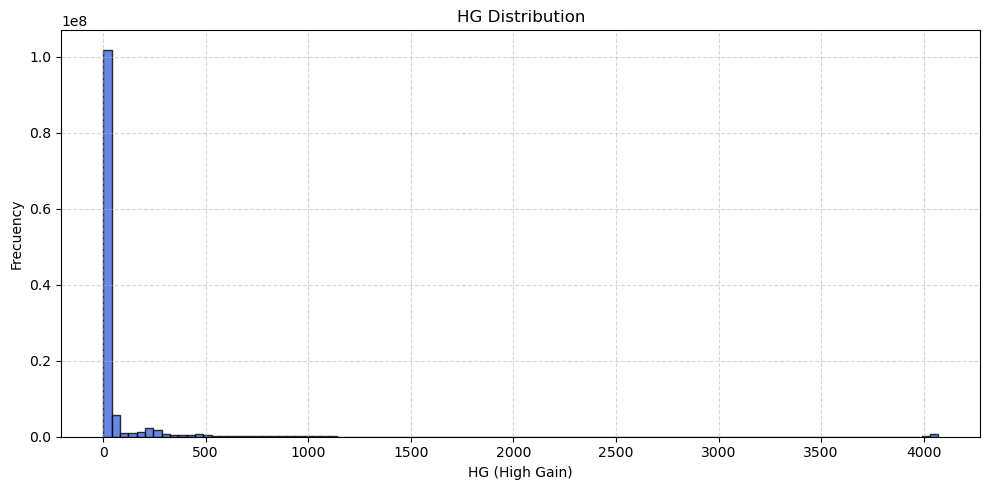

In [17]:
plot_HG_distribution(df2)

# Sincronization Correction

In [18]:
len(triggers_D2)-len(triggers_D1)

2

In [19]:
indexes = [322324, 755791]
#indexes = [2648,32225,32662]

triggers_D2 = [trigger for i, trigger in enumerate(triggers_D2) if i not in indexes]

Mean Δt: 51356.52 µs
Standard deviation: 30876.84 µs
Slope: 0.05445 ± 9.693e-07 µs/event
R²: 0.998876


c:\Users\Quant\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


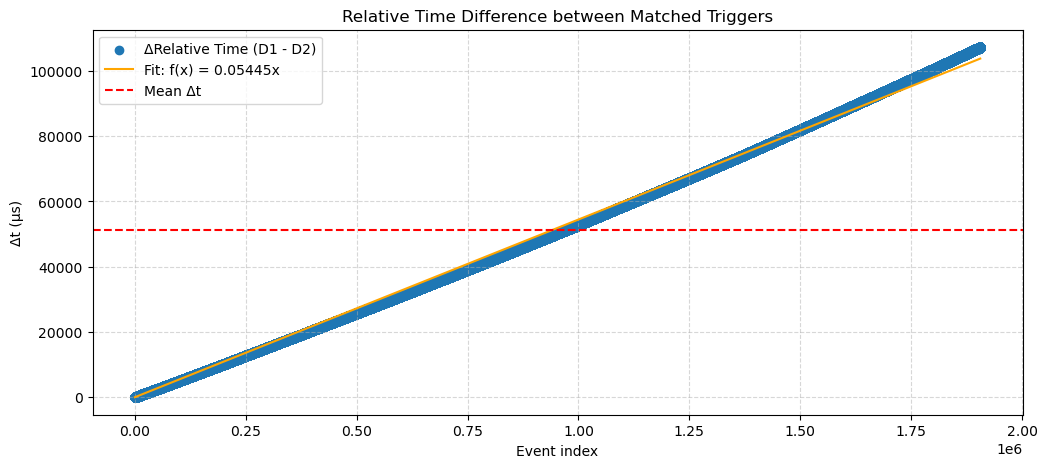

In [20]:
dif = coincidences_verification(list(zip(triggers_D1, triggers_D2)))

# Efficiencies

In [21]:
X_D1 = list(range(0, 29))
Y_D1 = list(range(32, 61))

X_D2 = list(range(0, 29))
Y_D2 = list(range(32, 61))

### Method 1

In [52]:
eff1, err1, C_7act1, C_8act1 = compute_efficiency1(triggers_D1, triggers_D2, X_D1, Y_D1, X_D2, Y_D2)

Processing coincidences: 100%|██████████| 1905687/1905687 [00:00<00:00, 2294062.04it/s]


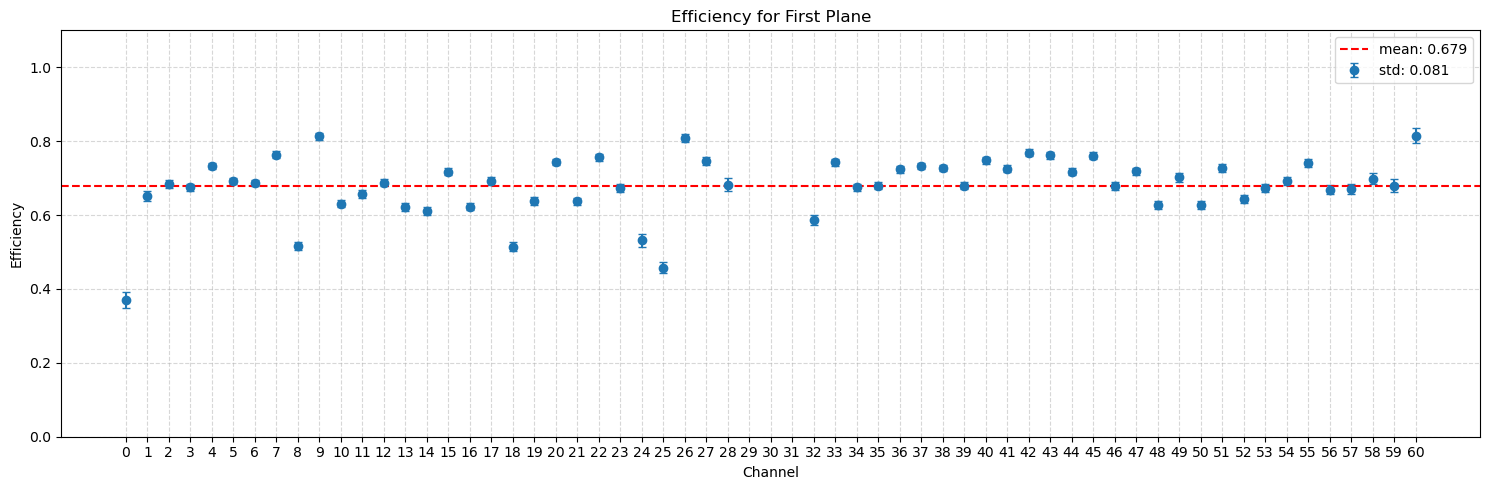

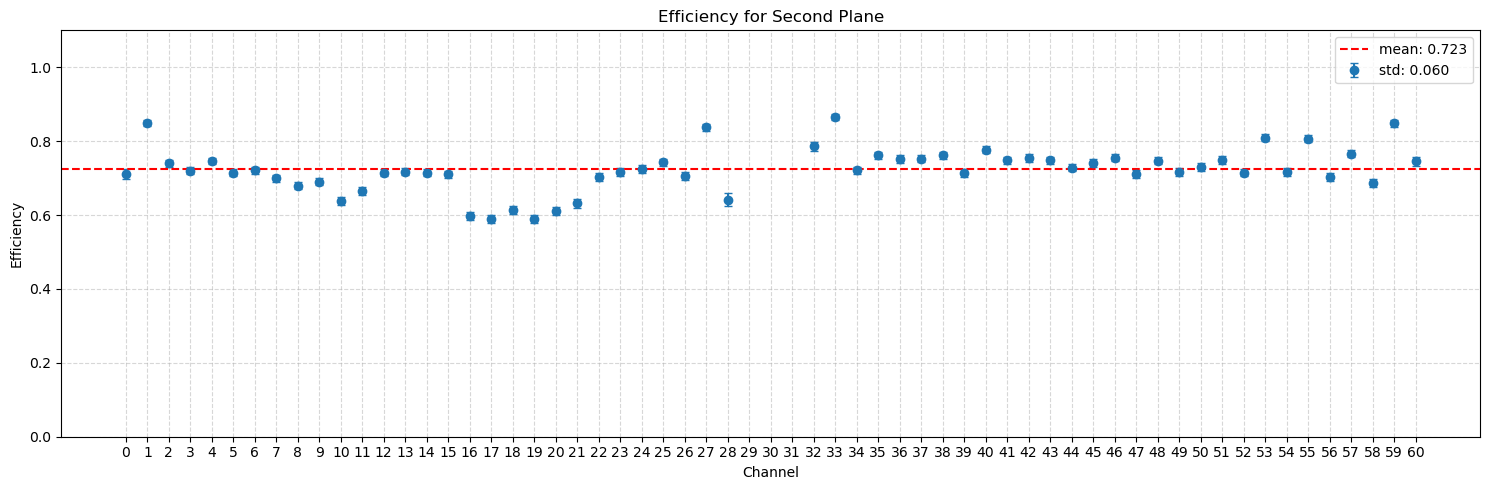

In [62]:
eff1_D1 = {**eff1[0], **eff1[1]}
err1_D1 = {**err1[0], **err1[1]}
eff1_D2 = {**eff1[2], **eff1[3]}
err1_D2 = {**err1[2], **err1[3]}

plot_efficiency_vs_channel(eff1_D1, err1_D1, title="Efficiency for First Plane")
plot_efficiency_vs_channel(eff1_D2, err1_D2, title="Efficiency for Second Plane")

### Method 2

In [56]:
eff2, err2, C_7act2, C_8act2  = compute_efficiency2(triggers_D1, triggers_D2, X_D1, Y_D1, X_D2, Y_D2)

Processing coincidences: 100%|██████████| 1905687/1905687 [08:35<00:00, 3693.30it/s]


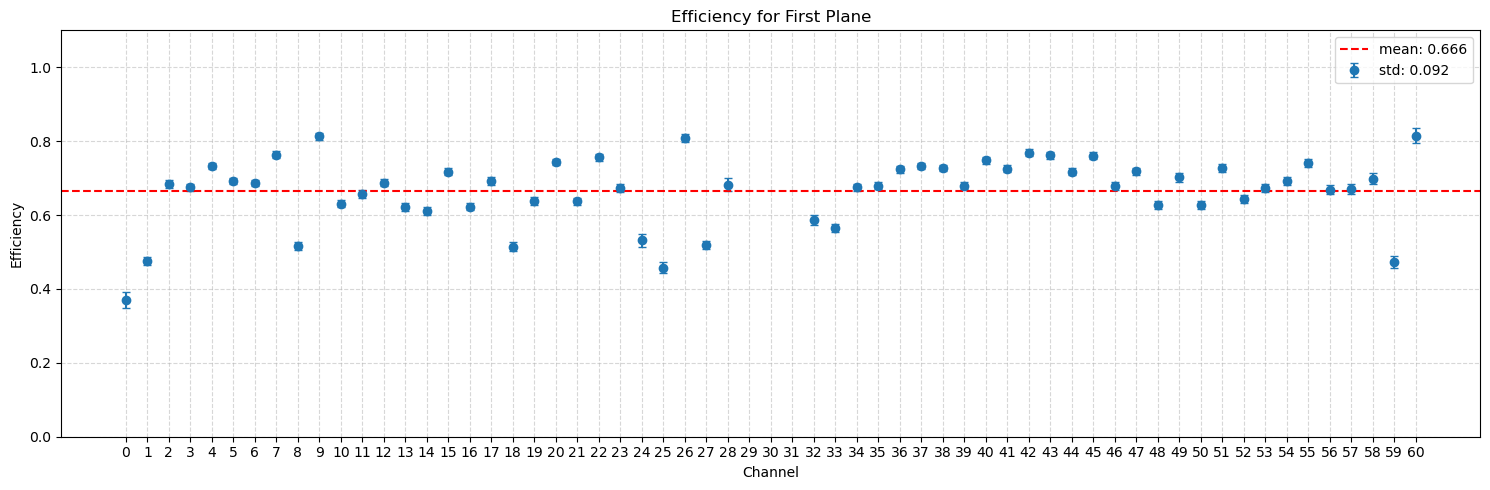

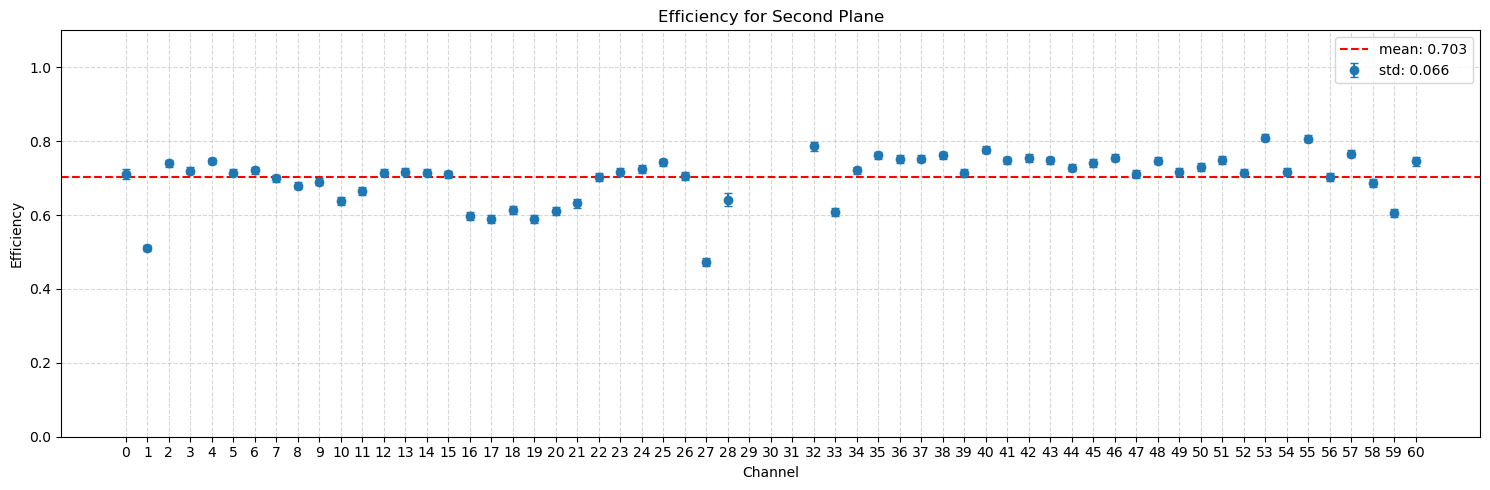

In [63]:
eff2_D1 = {**eff2[0], **eff2[1]}
err2_D1 = {**err2[0], **err2[1]}
eff2_D2 = {**eff2[2], **eff2[3]}
err2_D2 = {**err2[2], **err2[3]}

plot_efficiency_vs_channel(eff2_D1, err2_D1, title="Efficiency for First Plane")
plot_efficiency_vs_channel(eff2_D2, err2_D2, title="Efficiency for Second Plane")

### Method 3

In [58]:
eff3_D1, err3_D1, C_3act3_D1, C_4act3_D1 = compute_efficiency3(triggers_D1, X_D1, Y_D1)
eff3_D2, err3_D2, C_3act3_D2, C_4act3_D2 = compute_efficiency3(triggers_D2, X_D2, Y_D2)

100%|██████████| 1905687/1905687 [06:10<00:00, 5147.61it/s]


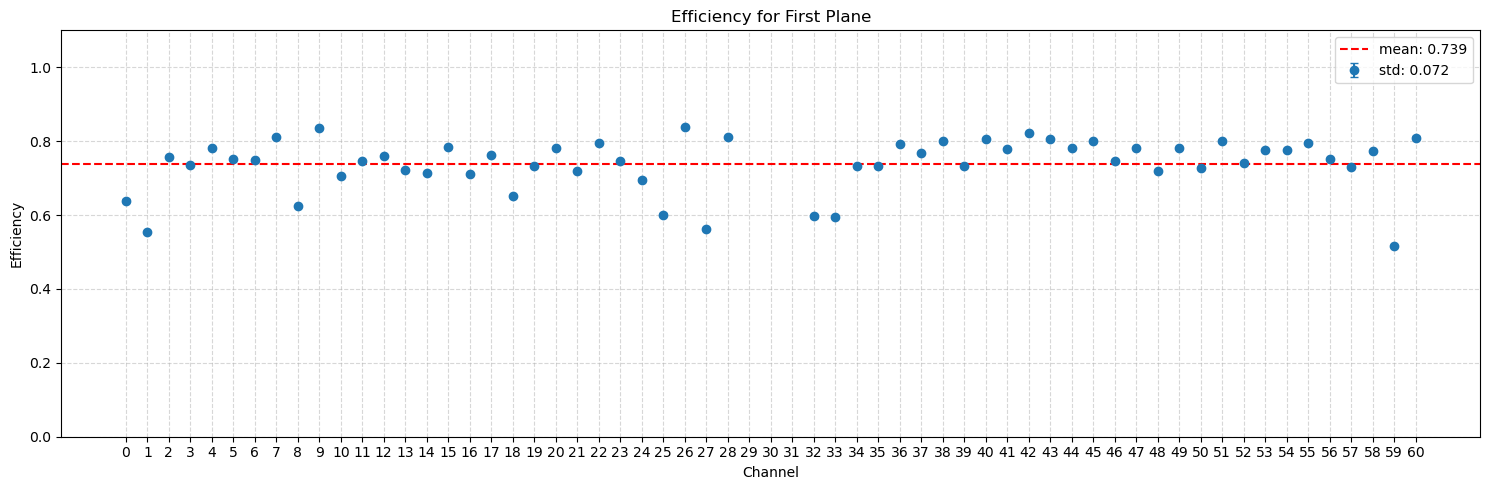

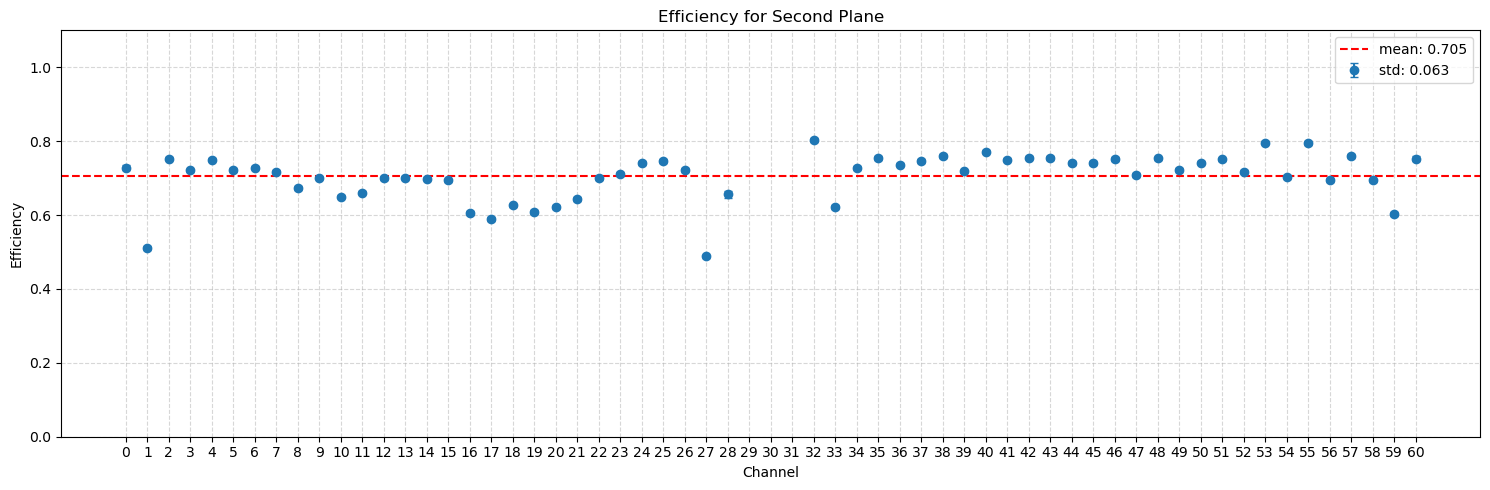

In [64]:
eff3_D1 = {**eff3_D1[0], **eff3_D1[1]}
err3_D1 = {**err3_D1[0], **err3_D1[1]}
eff3_D2 = {**eff3_D2[0], **eff3_D2[1]}
err3_D2 = {**err3_D2[0], **err3_D2[1]}

plot_efficiency_vs_channel(eff3_D1, err3_D1, title="Efficiency for First Plane")
plot_efficiency_vs_channel(eff3_D2, err3_D2, title="Efficiency for Second Plane")

### Method 4

In [60]:
eff4_D1, err4_D1, C_3act4_D1, C_4act4_D1 = compute_efficiency4(triggers_D1, X_D1, Y_D1)
eff4_D2, err4_D2, C_3act4_D2, C_4act4_D2 = compute_efficiency4(triggers_D2, X_D2, Y_D2)

100%|██████████| 1905687/1905687 [00:00<00:00, 2913316.54it/s]


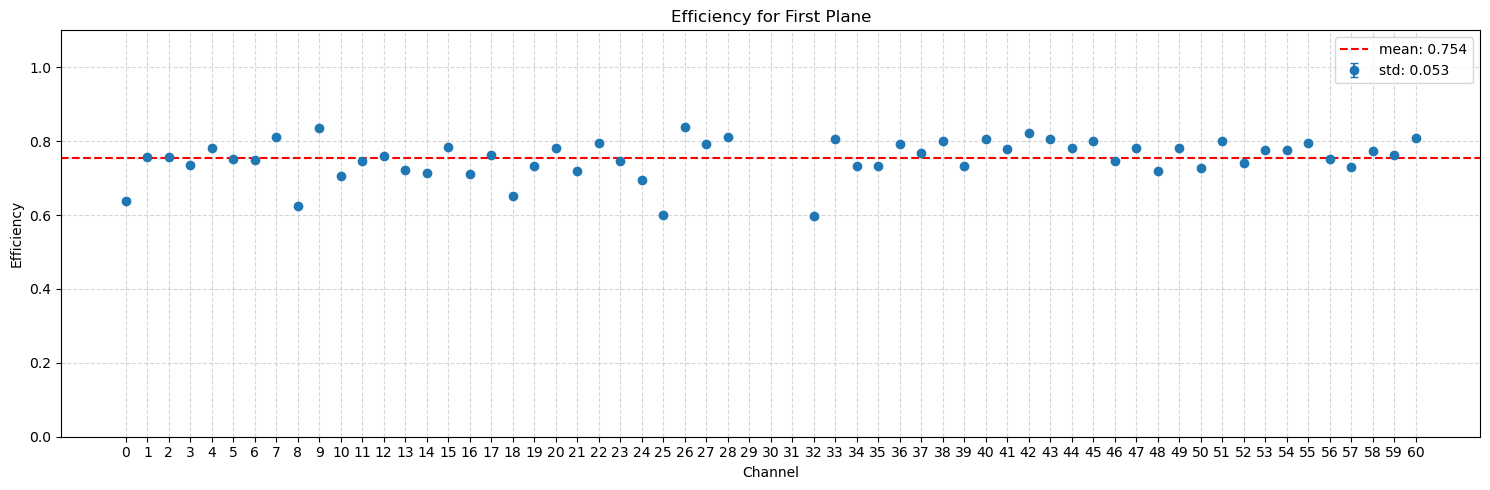

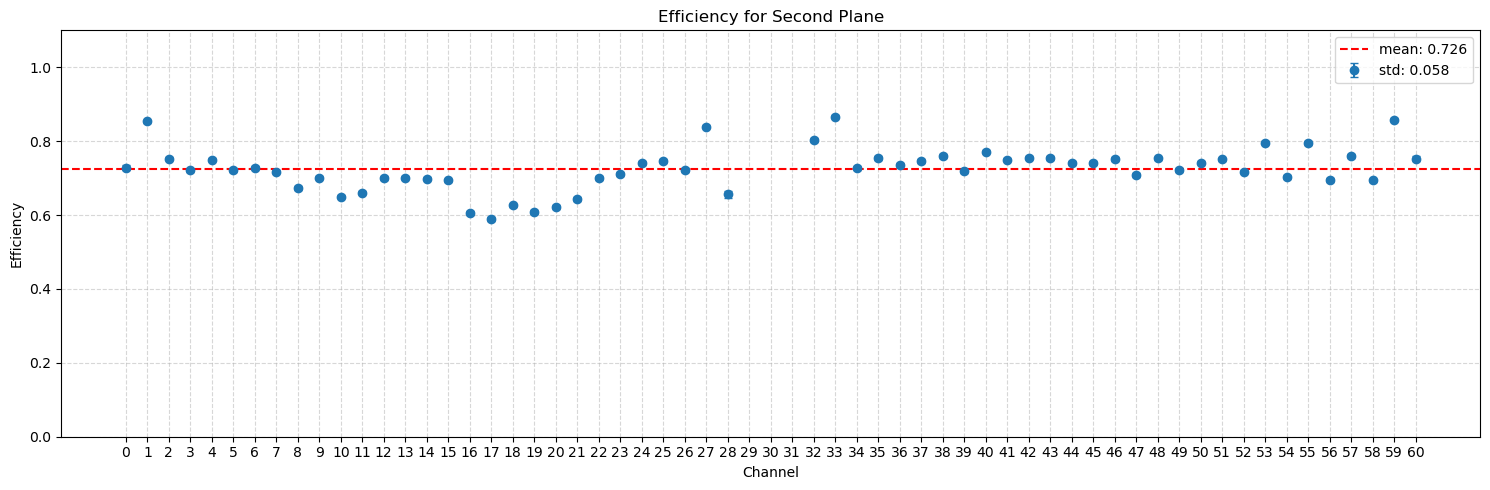

In [65]:
eff4_D1 = {**eff4_D1[0], **eff4_D1[1]}
err4_D1 = {**err4_D1[0], **err4_D1[1]}
eff4_D2 = {**eff4_D2[0], **eff4_D2[1]}
err4_D2 = {**err4_D2[0], **err4_D2[1]}

plot_efficiency_vs_channel(eff4_D1, err4_D1, title="Efficiency for First Plane")
plot_efficiency_vs_channel(eff4_D2, err4_D2, title="Efficiency for Second Plane")

### Methods Comparison

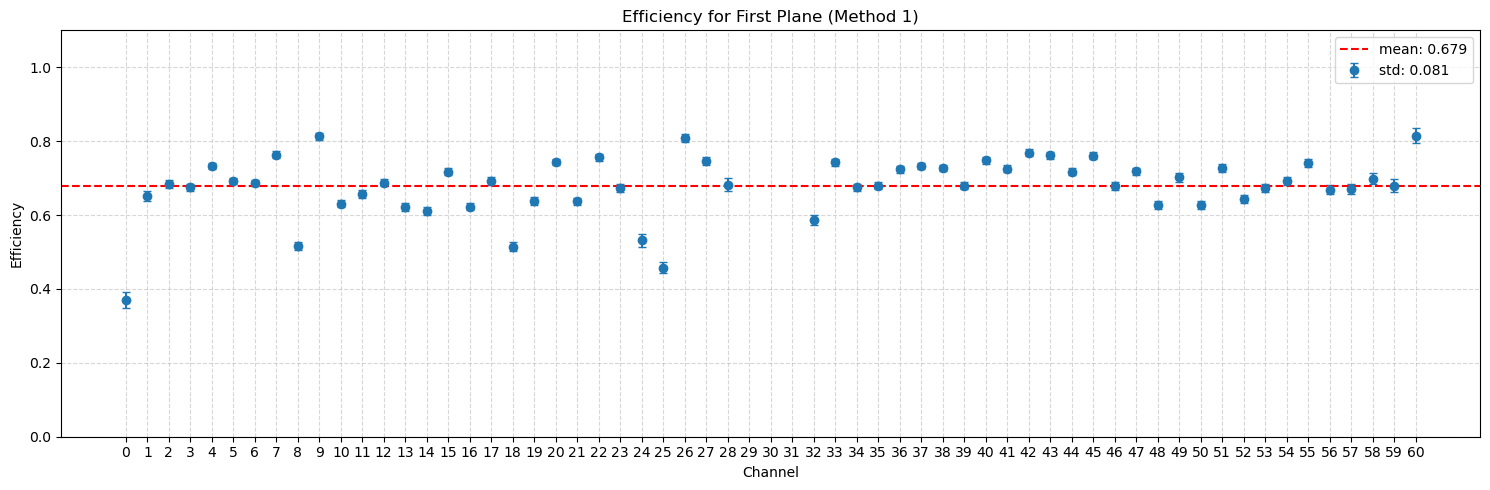

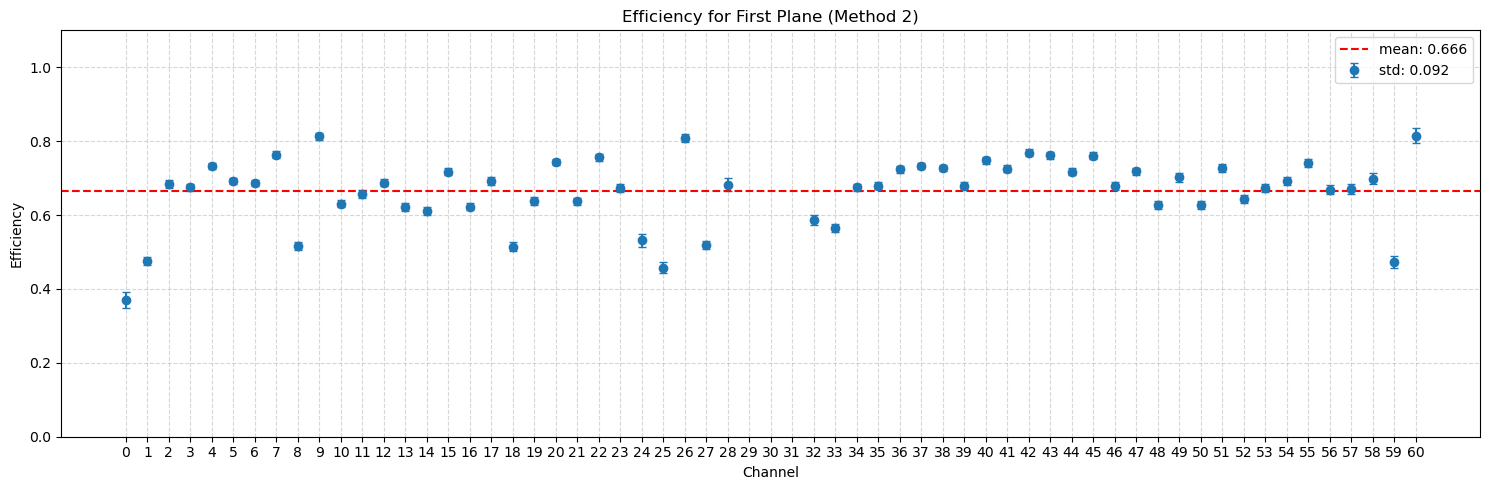

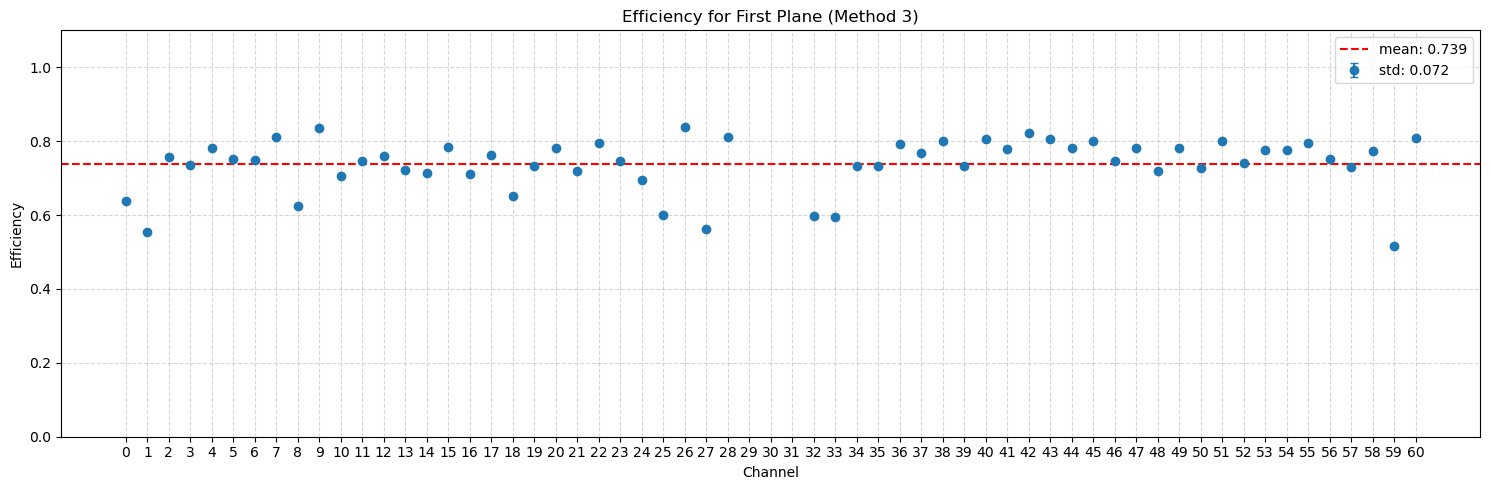

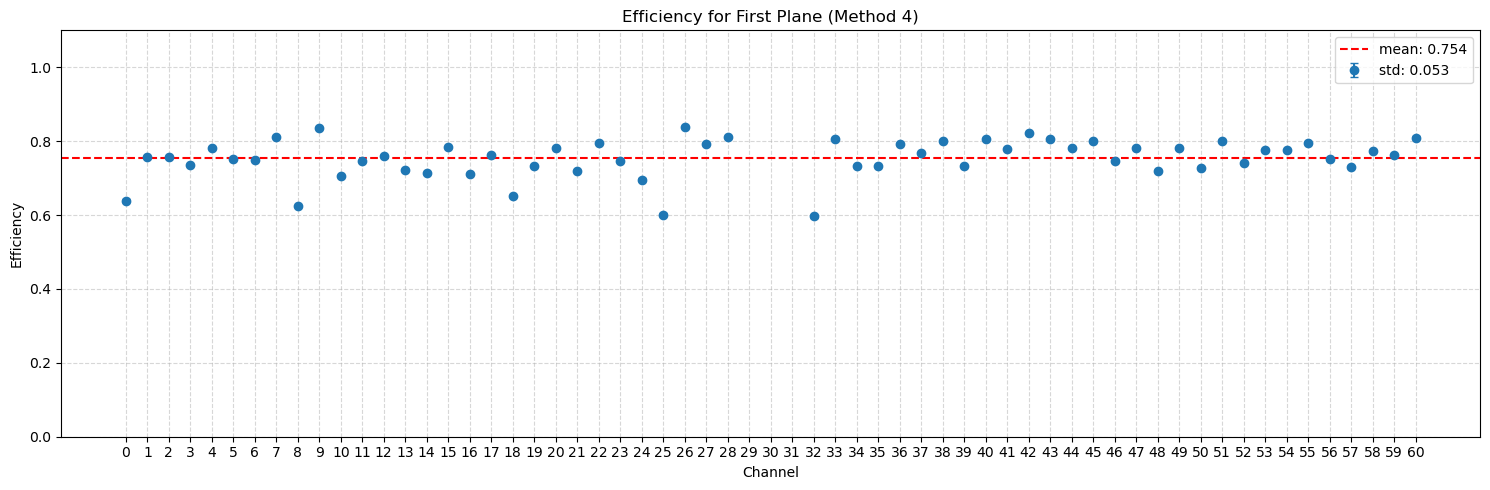

In [66]:
plot_efficiency_vs_channel(eff1_D1, err1_D1, title="Efficiency for First Plane (Method 1)")
plot_efficiency_vs_channel(eff2_D1, err2_D1, title="Efficiency for First Plane (Method 2)")
plot_efficiency_vs_channel(eff3_D1, err3_D1, title="Efficiency for First Plane (Method 3)")
plot_efficiency_vs_channel(eff4_D1, err4_D1, title="Efficiency for First Plane (Method 4)")

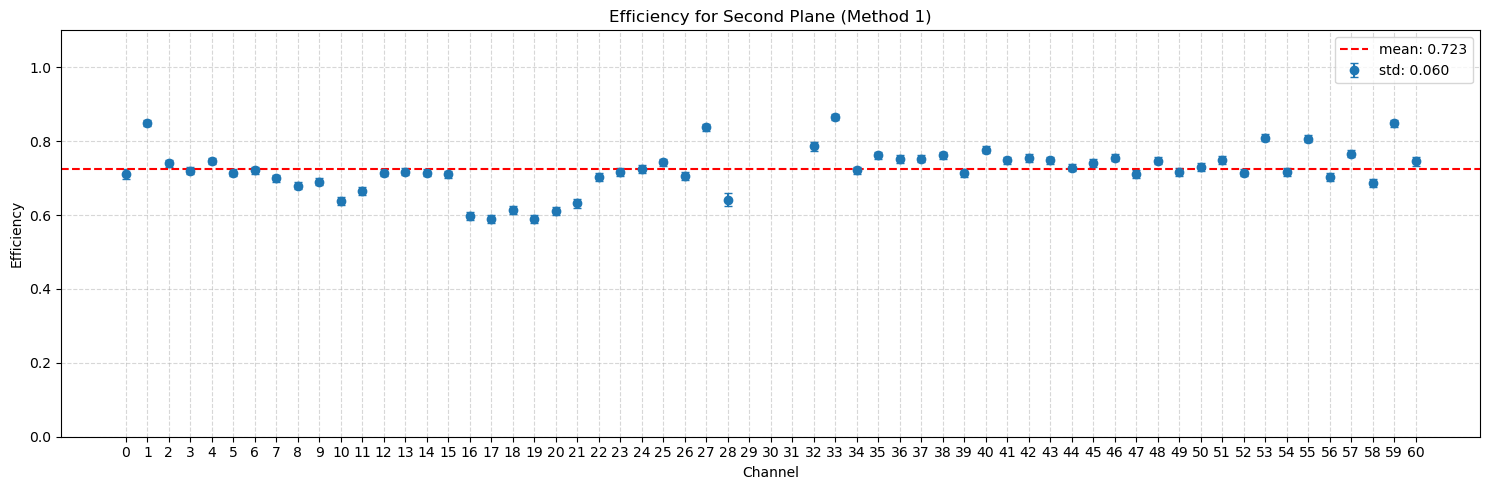

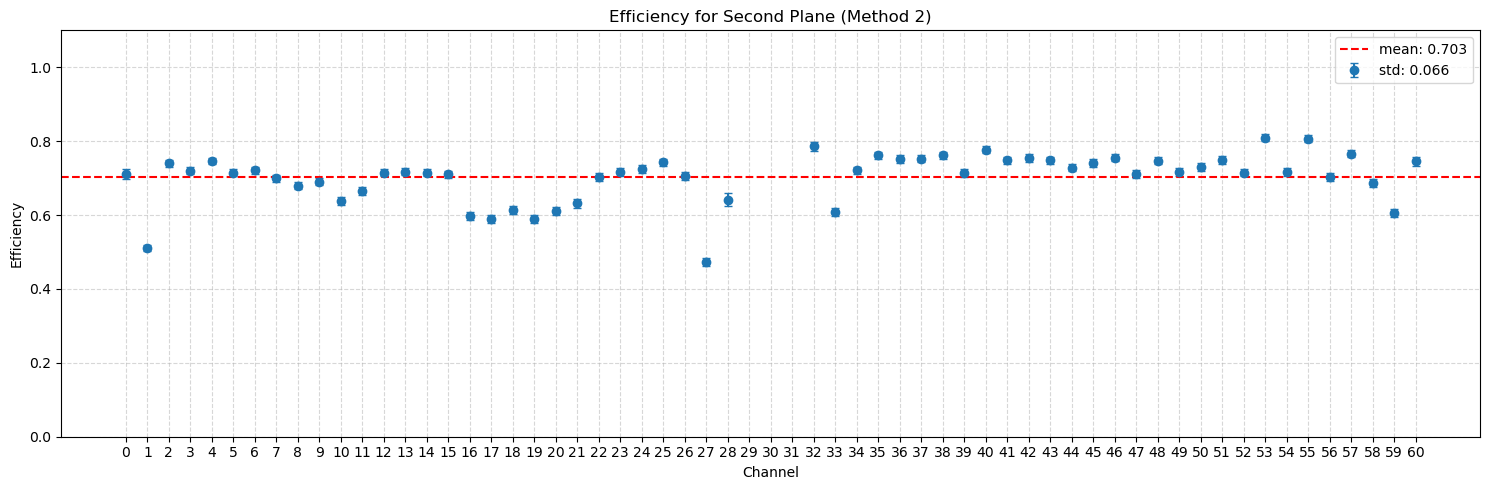

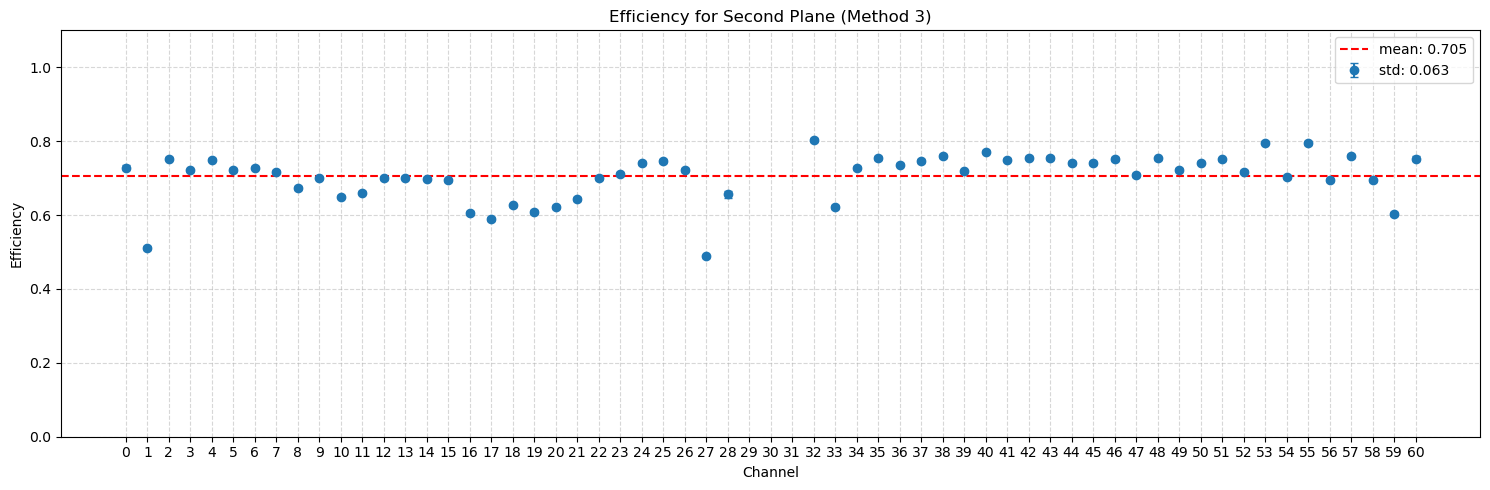

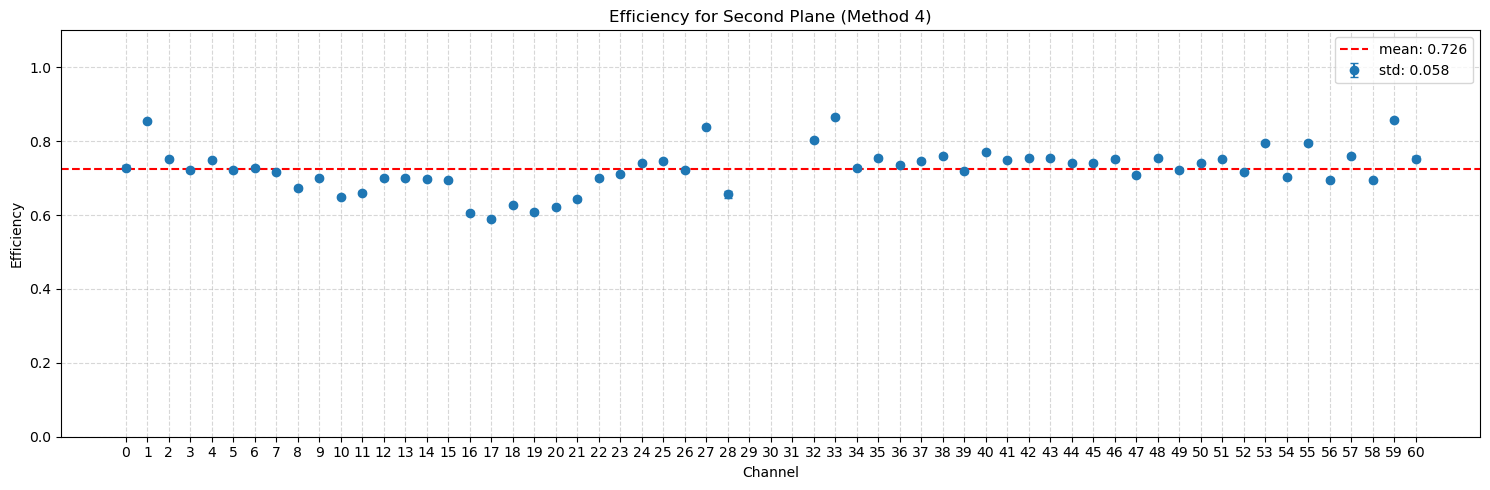

In [67]:
plot_efficiency_vs_channel(eff1_D2, err1_D2, title="Efficiency for Second Plane (Method 1)")
plot_efficiency_vs_channel(eff2_D2, err2_D2, title="Efficiency for Second Plane (Method 2)")
plot_efficiency_vs_channel(eff3_D2, err3_D2, title="Efficiency for Second Plane (Method 3)")
plot_efficiency_vs_channel(eff4_D2, err4_D2, title="Efficiency for Second Plane (Method 4)")